In [27]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [42]:
%%cython
import time
def program():
    cdef int i, j
    cdef int N = 10000
    for i in range(N):
        for j in range(N):
            pass
start = time.time()
program()
print(time.time() - start)

In [36]:
import time
n = 10000
def program():
    for i in range(n):
        for j in range(n):
            pass
start = time.time()
program()
print(time.time() - start)

1.9676272869110107


In [1]:
import pandas as pd
from polarization_estimator import ModelPolarization
from tqdm import trange
import gc
from matplotlib import pyplot as plt
import numpy as np
import json
from statsmodels.graphics.tsaplots import plot_acf

In [35]:
def run_models():
    results = {"date":[], "plugin":[], "leaveout":[]}
    date = pd.Period('2020-02-23', 'D') 
    for _ in trange(65):
        date += 1
        gov_data = pd.read_csv("data/clean/gov_tweets_clean.csv", header = 0, index_col = False, dtype = str)
        gov_data["source"] = "government"
        gov_data = gov_data.loc[gov_data.created_at.notna()]
        gov_data = gov_data.drop(columns = ["index"])
        gov_data["created_at"] = pd.to_datetime(gov_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")
        gov_data["day"] = gov_data.created_at.dt.to_period("D")
        gov_data = gov_data.loc[gov_data["day"] == date].reset_index()

        opp_data = pd.read_csv("data/clean/opp_tweets_clean.csv", header = 0, index_col = False, dtype = str)
        opp_data["source"] = "opposition"
        opp_data = opp_data.loc[opp_data.created_at.notna()]
        opp_data = opp_data.drop(columns = ["index"])
        opp_data["created_at"] = pd.to_datetime(opp_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")
        opp_data["day"] = opp_data.created_at.dt.to_period("D")
        opp_data = opp_data.loc[opp_data["day"] == date].reset_index()


        tweet_data = pd.concat([gov_data, opp_data], axis = 0)
        del(gov_data)
        del(opp_data)
        gc.collect()

        tweet_data.dropna(subset = ["source","preprocessed"], inplace = True)

        model = ModelPolarization(tweet_data["source"].tolist(), tweet_data["user-id_str"].tolist(), tweet_data["preprocessed"].tolist())
        results["date"].append(date)
        results["plugin"].append(model.plug_in())
        results["leaveout"].append(model.leave_out())
    results["date"] = list(map(lambda x: x.strftime("%Y-%m-%d"), results["date"]))
    return results

In [ ]:
def run_models():
    results = {"date":[], "plugin":[], "leaveout":[]}
    date = pd.Period('2020-02-22', 'D') 
    for _ in trange(65):
        date += 1
        datestr = date.strftime("%Y_%m_%d")
        
        
        path = "data/clean/gov_tweets_clean_" + datestr + ".csv"
        gov_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
        gov_data["source"] = "government"
        gov_data = gov_data.loc[gov_data.created_at.notna()]
        gov_data = gov_data.drop(columns = ["index"])
        
        
        path = "data/clean/opp_tweets_clean_" + datestr + ".csv"
        opp_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
        opp_data["source"] = "opposition"
        opp_data = opp_data.loc[opp_data.created_at.notna()]
        opp_data = opp_data.drop(columns = ["index"])


        tweet_data = pd.concat([gov_data, opp_data], axis = 0)
        del(gov_data)
        del(opp_data)
        gc.collect()

        tweet_data.dropna(subset = ["source","preprocessed"], inplace = True)

        model = ModelPolarization(tweet_data["source"].tolist(), tweet_data["user-id_str"].tolist(), tweet_data["preprocessed"].tolist())
        results["date"].append(date)
        results["plugin"].append(model.plug_in())
        results["leaveout"].append(model.leave_out())
    results["date"] = list(map(lambda x: x.strftime("%Y-%m-%d"), results["date"]))
    return results

In [36]:
if os.path.isfile("polarization_estimates.json"):
    results = json.load(open("polarization_estimates.json","r"))
else:
    results = run_models()
    json.dump(results, open("polarization_estimates.json","w"))

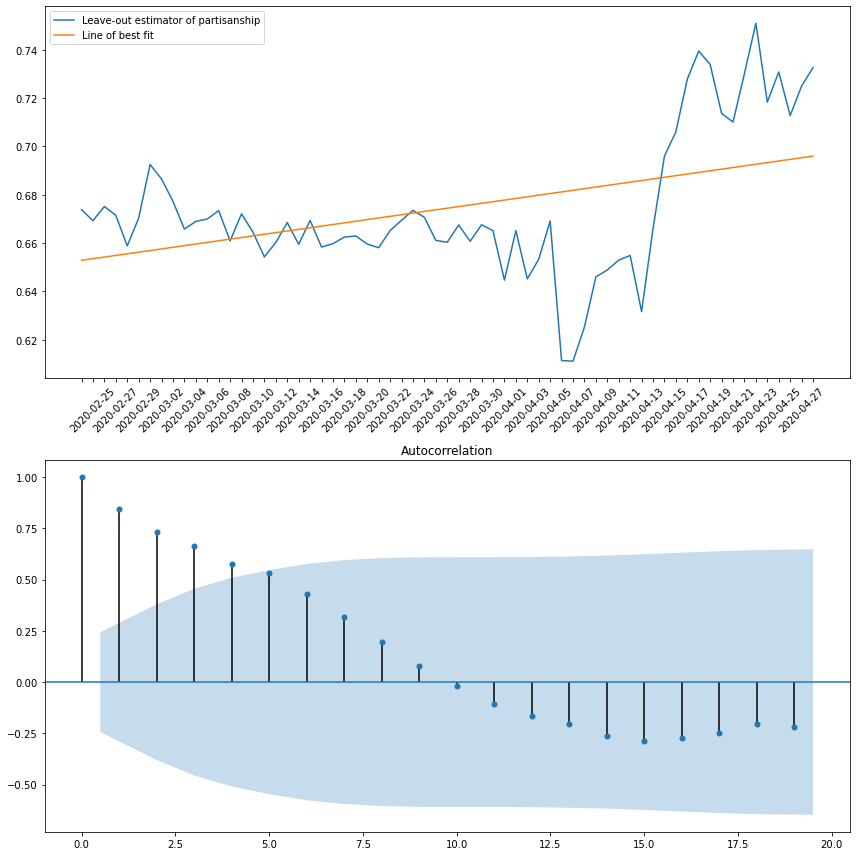

In [30]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(2,1,1)
ax.plot(results["date"],results["leaveout"])
#ax.plot(results["date"],res["plugin"])
ax.plot(np.unique(range(65)), np.poly1d(np.polyfit(range(65), results["leaveout"], 1))(np.unique(range(65))))
ax.xaxis.set_tick_params(rotation=45)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.legend(["Leave-out estimator of partisanship", "Line of best fit"])
ax = fig.add_subplot(2,1,2)
plot_acf(np.array(results["leaveout"]), ax = ax)
plt.tight_layout()
plt.show()